In [3]:
import pandas as pd
from scipy.stats import poisson
import numpy as np

In [4]:
def datos(url0,urlpartido0,url1,urlpartido1):
    """
    Extrae datos de las tablas HTML de las URLs proporcionadas y crea DataFrames.
    
    Args:
    - url0: URL para obtener datos
    - urlpartido0: URL para obtener datos de partidos
    - url1: URL para obtener datos
    - urlpartido1: URL para obtener datos de partidos
    
    Returns:
    Dos DataFrames, uno con datos de partidos actuales y otro con datos de partidos pasados.
    """
    datosActual=pd.read_html(url0)
    datosPasada=pd.read_html(url1)
    datosxpartido1=pd.read_html(urlpartido0)
    datosxpartido2=pd.read_html(urlpartido1)
    partidoxActual=pd.DataFrame(datosxpartido1[0])#actual
    partidoxPasada=pd.DataFrame(datosxpartido2[0])#data pasada
    partido=pd.DataFrame(datosxpartido1[0])#actual
    return partidoxActual, partidoxPasada,datosActual,datosPasada

In [5]:
def PremierLeague():
    """
    Carga los url del partido
    Args:
    Returns:
    String con los Url
    """
    # URLs de estadísticas generales de la Premier League
    url0 = "https://fbref.com/es/comps/9/Estadisticas-de-Premier-League"
    
    # URLs de horario y resultados de partidos de la Premier League
    urlpartido0 = "https://fbref.com/es/comps/9/horario/Resultados-y-partidos-en-Premier-League"
    
    # URLs de estadísticas de la temporada 2022-2023 de la Premier League
    url1 = "https://fbref.com/es/comps/9/2022-2023/Estadisticas-2022-2023-Premier-League"
    
    # URLs de horario y marcadores de partidos de la temporada 2022-2023 de la Premier League
    urlpartido1 = "https://fbref.com/es/comps/9/2022-2023/horario/Marcadores-y-partidos-de-2022-2023-Premier-League"
    #
    partidoxActual, partidoxPasada,datosActual,datosPasada=datos(url0,urlpartido0,url1,urlpartido1)
    # Devuelve las cuatro URLs
    return partidoxActual, partidoxPasada,datosActual,datosPasada

In [6]:
partidoxActual,partidoxPasada,datosActual,datosPasada=PremierLeague()

In [7]:
sem=9
numEquipos=len(datosActual[0]["Equipo"])
equiposActuales=pd.DataFrame(datosActual[0]["Equipo"])
filtered_rows = partidoxActual.loc[partidoxActual['Sem.'] == sem]
filtered_max =int(partidoxPasada["Sem."].max())

In [8]:
def ordenarEquipos(data):
    
    #para qu no halla error si se ejecuta dos veces control de errores
    if data.columns.nlevels > 1:
        data = data.droplevel(0, axis=1)
    filas_correspondientes = pd.DataFrame()  # Inicializa el DataFrame vacío para almacenar los resultados

    for i in range(numEquipos):
        nombre_a_buscar = equiposActuales.iloc[i, 0]

        # Buscar el equipo en el DataFrame actual
        if nombre_a_buscar in data["Equipo"].values:
            fila_correspondiente = data[data["Equipo"] == nombre_a_buscar]
            if fila_correspondiente.iloc[0]["Tipo"] == "Visitante":#esta parte del code se usa para intercambiar los marcadores si son visitantes
                fila_correspondiente = fila_correspondiente.copy()
                fila_correspondiente["Hechos"], fila_correspondiente["Recibidos"] = fila_correspondiente["Recibidos"], fila_correspondiente["Hechos"]
        else:
            # Si el equipo no se encuentra, crea una fila de ceros
            fila_ceros = pd.DataFrame(0, index=[0], columns=data.columns)
            fila_ceros["Equipo"] = nombre_a_buscar
            fila_correspondiente = fila_ceros
            
        filas_correspondientes = pd.concat([filas_correspondientes, fila_correspondiente], ignore_index=True)
        
    return filas_correspondientes

In [9]:
def calculartable(data):
    new_data = []  # Lista para almacenar los datos de las filas

    for i in range(len(data)):
        Sem=data["Sem."][i]
        Equipo = data["Equipo"][i]
        Tipo = data["Tipo"][i]
    
        if Tipo == "Local":
            Ganado = data["G"][i]
            Empatado = data["E"][i]
            Perdido = data["P"][i]
            Gf = data["Hechos"][i]
            Gc = data["Recibidos"][i]
        
            new_data.append({
                'Sem.':Sem,
                'Equipo': Equipo,
                'PJ(Local)': 1,
                'PG(Local)': Ganado,
                'PE(Local)': Empatado,
                'PP(Local)': Perdido,
                'GF(Local)': Gf,
                'GC(Local)': Gc,
                'PJ(Visitante)': 0,
                'PG(Visitante)': 0,
                'PE(Visitante)': 0,
                'PP(Visitante)': 0,
                'GF(Visitante)': 0,
                'GC(Visitante)': 0
            })
    
        elif Tipo == "Visitante":
            Ganado = data["G"][i]
            Empatado = data["E"][i]
            Perdido = data["P"][i]
            Gf = data["Hechos"][i]
            Gc = data["Recibidos"][i]
            new_data.append({
                'Sem.':Sem,
                'Equipo': Equipo,
                'PJ(Local)': 0,
                'PG(Local)': 0,
                'PE(Local)': 0,
                'PP(Local)': 0,
                'GF(Local)': 0,
                'GC(Local)': 0,
                'PJ(Visitante)': 1,
                'PG(Visitante)': Ganado,
                'PE(Visitante)': Empatado,
                'PP(Visitante)': Perdido,
                'GF(Visitante)': Gf,
                'GC(Visitante)': Gc
            })

    # Crear un DataFrame a partir de la lista de datos
    df = pd.DataFrame(new_data)
    return df

In [10]:
def organizarfiltered_rows(data):
    """
    Crea el DataFrame `dataprepared` con ciertas columnas e inicializa algunas de sus columnas con ceros.
    Luego, copia valores de `data` a `prevdados` en ciertas filas.
    Args:
    data(DataFrame): DataFrame que contiene la información sobre los partidos.
    Returns:
    DataFrame `dataprepared` creado y modificado.
    """
    # Crear DataFrame a partir de los datos
    dataprepared = pd.DataFrame(data)
    
    # Renombrar columnas
    nuevos_nombres = {'Sem.': 'Rodada', 'Local': 'Time1', 'Visitante': 'Time2'}
    dataprepared = dataprepared.rename(columns=nuevos_nombres)  # Asignar el DataFrame resultante a prevdados
    
    # Dividir el marcador en dos columnas (Goles Local y Goles Visitante)
    dataprepared[['GFM', 'GSM']] = dataprepared['Marcador'].str.split('–', expand=True)
    dataprepared[['GSV', 'GFV']] = dataprepared['Marcador'].str.split('–', expand=True)
    
    # Eliminar la columna 'Marcador' original
    dataprepared = dataprepared.drop(columns=['Marcador'])
    orden_columnas=["Time1","Time2","Rodada","GFM","GSM","GSV","GFV"]
    dataprepared=dataprepared[orden_columnas]
    return dataprepared

In [11]:
def calculardatosunion(data):
    data_drop = data.drop(["Día", "Hora", "Asistencia", "Sedes", "Árbitro", "Informe del partido", "Notas", "Fecha","xG","xG.1"], axis=1)
    dataprepared= pd.DataFrame(organizarfiltered_rows(data_drop))
    return dataprepared

In [12]:
limpia=partidoxActual.dropna(subset=["Marcador"])
filtered1 =int(limpia["Sem."].max())
data=calculardatosunion(partidoxActual)

In [13]:
import pandas as pd

def criar_prevdados(data, rodada, n_partidas):
    """
    Crea el DataFrame `prevdados` con ciertas columnas e inicializa algunas de sus columnas con ceros.
    Luego, copia valores de `data` a `prevdados` en ciertas filas.

    Args:
    data(DataFrame): DataFrame que contiene la información sobre los partidos.
    rodada(int): Número de la ronda que se desea ejecutar.
    n_partidas(int): Número de partidas por ronda en el torneo.

    Returns:
    DataFrame `prevdados` creado y modificado.
    """
    # Crea un DataFrame con las columnas `Time1`, `Time2`, `Rodada`, `GFM`, `GSM`, `GSV`, `GFV`.
    prevdados = pd.DataFrame(data[['Time1', 'Time2', 'Rodada']], columns=['Time1', 'Time2', 'Rodada'])

    # Inicializa las columnas `GFM`, `GSM`, `GSV`, `GFV` con 0.
    prevdados['GFM'] = 0
    prevdados['GSM'] = 0
    prevdados['GSV'] = 0
    prevdados['GFV'] = 0

    # Copia los valores de las columnas `GFM`, `GSM`, `GSV`, `GFV` de las primeras `(rodada - 1) * n_partidas` filas de `data` a `prevdados`.
    # Rellenar los valores NaN con cero antes de la conversión a entero
    prevdados.iloc[0:((rodada - 1) * n_partidas), 3:7] = data.iloc[0:((rodada - 1) * n_partidas), 3:7].fillna(0).astype(int)

    return prevdados

In [14]:
rondada=38#numero la ronda
n_partidas=10#partidos en la liga
prevdados=criar_prevdados(data,rondada,n_partidas)
prevdados = prevdados.dropna()

In [15]:
TablaPasadaLocal=datosPasada[1]["Local"]
TablaPasadaVisitante=datosPasada[1]["Visitante"]

In [16]:
"""
Para definir las constanes generales:
meanCBPfm: Media de goles esperados por partido para equipos mandantes.
meanCBPsm: Media de goles esperados por partido para equipos visitantes.
meanCBPfv: Media de goles esperados por partido para equipos que reciben goles.
meanCBPsv: Media de goles esperados por partido para equipos que marcan goles.
Se Toman los promedios de la temporada pasada 
"""
n_partidosLocal=TablaPasadaLocal["PJ"].sum()
n_partidosVisitante=TablaPasadaVisitante["PJ"].sum()
meanCBPfm=(TablaPasadaLocal["GF"].sum())/n_partidosLocal
print(meanCBPfm)
meanCBPsm=(TablaPasadaVisitante["GF"].sum())/n_partidosVisitante
print(meanCBPsm)
meanCBPfv=(TablaPasadaLocal["GC"].sum())/n_partidosLocal
print(meanCBPfv)
meanCBPsv=(TablaPasadaVisitante["GC"].sum())/n_partidosVisitante
print(meanCBPsv)


1.6342105263157896
1.2184210526315788
1.2184210526315788
1.6342105263157896


In [17]:
def meanCBPfm_atual(prevdados,i,meanCBPfm):
    """
    Calcula el resultado ngols basado en los criterios Goles a favor x contante de la media .

    Args:
    prevdados(DataFrame): DataFrame que contiene la información sobre los partidos.
    i(int): Número de la ronda que se desea ejecutar.
    meanCBPfm(int): Coeficiente multiplicador para calcular ngols

    Returns:
    Serie que representa el resultado calculado ngols.
    """

    #Organización de datos que itera los valores claves y los cuenta según sus valores min y max.
    filtro = prevdados["Rodada"] <= i
    a=prevdados[filtro]
    df_grouped = a.groupby("Time1")["GFM"].value_counts().unstack()
    #Suma las colomunas segun los puntos obtenidos
    numxfilas=df_grouped.sum(axis=1)
    #Multiplica el coheficiente meanCBPm por los datos en la tabla
    ngols=df_grouped.mul(meanCBPfm)#por la media de goles
    #Suma los valores de la filas para ngols
    ngols=ngols.sum(axis=1)
    #Divide  la suma
    resultado=ngols/(numxfilas + 1) #el mas uno se usa para tener una media de dato mas menos flexible
    return resultado

In [18]:
def meanCBPsm_atual(prevdados,i,meanCBPsm):
    """
    Calcula el resultado ngols basado en los criterios Goles a favor x contante de la media .

    Args:
    prevdados(DataFrame): DataFrame que contiene la información sobre los partidos.
    i(int): Número de la ronda que se desea ejecutar.
    meanCBPsm(int): Coeficiente multiplicador para calcular ngols.

    Returns:
    Serie que representa el resultado calculado ngols.
    """

    #Organización de datos que itera los valores claves y los cuenta según sus valores min y max.
    filtro = prevdados["Rodada"] <= i
    df_grouped = prevdados[filtro].groupby("Time1")["GFM"].value_counts().unstack()
    #Suma las colomunas segun los puntos obtenidos
    numxfilas=df_grouped.sum(axis=1)
    #Multiplica el coheficiente meanCBPm por los datos en la tabla
    ngols=df_grouped.mul(meanCBPsm)#por la media de goles
    #Suma los valores de la filas para ngols
    ngols=ngols.sum(axis=1)
    #Divide  la suma
    resultado=ngols/(numxfilas + 1) #el mas uno se usa para tener una media de dato mas menos flexible
    return resultado

In [19]:
def meanCBPfv_atual(prevdados,i,meanCBPfv):
    """
    Calcula el resultado ngols basado en los criterios Goles a favor x contante de la media .

    Args:
    prevdados(Dataframe): DataFrame que contiene la información sobre los partidos.
    i(int): Número de la ronda que se desea ejecutar.
    meanCBPfv(int): Coeficiente multiplicador para calcular ngols.

    Returns:
    Serie que representa el resultado calculado ngols.
    """
    #Organización de datos que itera los valores claves y los cuenta según sus valores min y max.
    filtro = prevdados["Rodada"] <= i #para que coja tada las tablas 
    a=prevdados[filtro]
    df_grouped = a.groupby("Time1")["GFM"].value_counts().unstack()
    #Suma las colomunas segun los puntos obtenidos
    numxfilas=df_grouped.sum(axis=1)
    #Multiplica el coheficiente meanCBPm por los datos en la tabla
    ngols=df_grouped.mul(meanCBPfv)#por la media de goles
    #Suma los valores de la filas para ngols
    ngols=ngols.sum(axis=1)
    #Divide  la suma
    resultado=ngols/(numxfilas + 1) #el mas uno se usa para tener una media de dato mas menos flexible
    return resultado

In [20]:
def meanCBPsv_atual(prevdados,i,meanCBPsv):
    """
    Calcula el resultado ngols basado en los criterios Goles a favor x contante de la media .

    Args:
    prevdados(DataFrame): DataFrame que contiene la información sobre los partidos.
    i(int): Número de la ronda que se desea ejecutar.
    meanCBPsv(int): Coeficiente multiplicador para calcular ngols.

    Returns:
    Serie que representa el resultado calculado ngols.
    """
    #Organización de datos que itera los valores claves y los cuenta según sus valores min y max.
    filtro = prevdados["Rodada"] <= i
    df_grouped = prevdados[filtro].groupby("Time1")["GFM"].value_counts().unstack()
    #Suma las colomunas segun los puntos obtenidos
    numxfilas=df_grouped.sum(axis=1)
    #Multiplica el coheficiente meanCBPm por los datos en la tabla
    ngols=df_grouped.mul(meanCBPsv)#por la media de goles
    #Suma los valores de la filas para ngols
    ngols=ngols.sum(axis=1)
    #Divide  la suma
    resultado=ngols/(numxfilas + 1) #el mas uno se usa para tener una media de dato mas menos flexible
    return resultado

In [21]:
def simaux(x,escala):
    """
    Calcula el resultado aproximado desiente ejemplo 1,1=1;1,9=1 reaclara los límites de máximo hasta 5 según la escala antes estipulada.

    Args:
    x(int): Valor a ser aproximado.
    escala(array): Lista de límites para la aproximación.

    Returns:
    Valor aproximado según la escala.
    """
    if x < escala[1]:
        return 0
    elif x >= escala[1] and x < escala[2]:
        return 1
    elif x >= escala[2] and x < escala[3]:
        return 2
    elif x >= escala[3] and  x < escala[4]:
        return 3
    elif x >=escala[4] and x < escala[5]:
        return 4
    elif x > escala[5]:
        return 5
    else:
        print("---error----")


In [22]:
def actulizar_prevpro(prevdado,rodada,nsim):
    """
    Actualizacion de las probabilidades victoria,empate y derrota para los partidos de la ronda actual
    Args:
    prevdado(Dataframe): Conjunto de datos DataFrame el cual contiene los resultados de los partidos
    rodada (int): ronda 
    nsim (int): numero de simulaciones realizadas
    Returns:
    DataFrame : DataFrame con las columnas "Time1","Time2","PVM","EMP","PVV"
    """
    #filtro para seleccionar las rondas especificas
    filtro=prevdado["Rodada"]==rodada
    x=prevdado[filtro]
    #asignacion de variables
    x["PVM"]=(x["GFM"] > x["GSM"]).astype(int) / nsim
    x["EMP"]=(x["GFM"] == x["GSM"]).astype(int) / nsim
    x["PVV"]=(x["GFM"] < x["GSM"]).astype(int) / nsim
    seleccion=x[["Time1","Time2","PVM","EMP","PVV"]]#devuelve solo esta columnas
    return seleccion

In [23]:
i=4
lauxfm=meanCBPfm_atual(prevdados,i,meanCBPfm)
lauxsv=meanCBPsv_atual(prevdados,i,meanCBPsv)
lauxfv=meanCBPfv_atual(prevdados,i,meanCBPfv)
lauxsm=meanCBPsm_atual(prevdados,i,meanCBPsm)
#contador de partidos por ronda
j=n_partidas*(i-1)+1
rango=j+n_partidas#salida 11,21,31.....
k=1
time1=prevdados.loc[k,"Time1"]
print(time1)
time2=prevdados.loc[k,"Time2"]
print(time2)
#Inicializacion de las variables las primeras son generales respecto al promedio anterior por eso tambien comienza en dos
if i==0:
#las variables generales de la temporada anterior
    lambdam=( meanCBPfm + meanCBPsv ) / 2
    lambdav=( meanCBPsm + meanCBPfv) / 2
else:
    try:
        # Intenta acceder a la columna 'time1' en el DataFrame
        lfm=lauxfm[time1]
    except KeyError:
    # Maneja la excepción si 'time1' no está presente en las columnas
        print("La columna lfm",time1,"no está presente en el DataFrame cambiar numero de ronda para que aparesca todos los equipos.")
    try:
        # Intenta acceder a la columna 'time2' en el DataFrame
        lsv=lauxsv[time2]
    except KeyError:
        # Maneja la excepción si 'time2' no está presente en las columnas
        print("La columna lsv",time2,"no está presente en el DataFrame cambiar numero de ronda para que aparesca todos los equipos.")
    try:
        # Intenta acceder a la columna 'time2' en el DataFrame
        lfv=lauxsv[time1]
    except KeyError:
        # Maneja la excepción si 'time' no está presente en las columnas
        print("La columna lfv",time1,"no está presente en el DataFrame cambiar numero de ronda para que aparesca todos los equipos.")
    try:
        # Intenta acceder a la columna 'time2' en el DataFrame
        lsm=lauxsv[time2]
    except KeyError:
    # Maneja la excepción si 'time' no está presente en las columnas
        print("La columna lsm",time2,"no está presente en el DataFrame cambiar numero de ronda para que aparesca todos los equipos.") 

Arsenal
Nott'ham Forest


In [133]:
def estado(resml, resmv):
    """
    Realiza la operación para determinar el estado de un partido.
    
    Args:
    resml (int): Resultado del equipo local.
    resmv (int): Resultado del equipo visitante.
    
    Returns:
    int: Estado del partido. 1 para ganado, 2 para empate, 3 para perdido.
    """
    g = 1
    e = 2
    p = 3
    estado1 = int(resml)
    estado2 = int(resmv)
    if estado1 > estado2:
        return g
    elif estado1 < estado2:
        return p
    elif estado1 == estado2:
        return e

In [41]:
eliminarNAN = partidoxActual.dropna(subset=['Marcador'])
filtered_row= (eliminarNAN["Sem."].max()).astype(int)
#filtered_row= 8
parametros=[]
for i in range(7,(filtered_row+1)):
    #se importan las medias de los datos en general tabla organizada
    lauxfm = meanCBPfm_atual(prevdados, i, meanCBPfm)
    lauxsv = meanCBPsv_atual(prevdados, i, meanCBPsv)
    lauxfv = meanCBPfv_atual(prevdados, i, meanCBPfv)
    lauxsm = meanCBPsm_atual(prevdados, i, meanCBPsm)
    #parametro paradeteriminar el rango de ciclo anidado
    fitro=prevdados["Rodada"]==i
    data=prevdados[fitro]
    iterador=len(data)
    for j in range(iterador):
        time1=data["Time1"].iloc[j]
        time2=data["Time2"].iloc[j]
        #Este metodo se usa en pyton si el metodo no se encuentra puede uno dejar un valor predeterminado
        lfm = lauxfm.get(time1, 0)
        lfv = lauxfv.get(time1,0)
        lsv = lauxsv.get(time2, 0)
        lsm = lauxsm.get(time2,0)

        #Esta es otra media para afirmar la dependencia de los equipos Local y Visitante 
        lambdam = (lfm + lsv) / 2
        lambdav = (lfv + lsm) / 2
        #valores limite
        valores = [0, 1, 2, 3, 4, 5]
        escm = poisson.cdf(valores, lambdam)
        escv = poisson.cdf(valores, lambdav)
        simm = np.random.rand(1)
        simv = np.random.rand(1)
        #simaux es un escaldo el cual aproxima desendientemente ejemplo: 1,6=1 para estipular los limites
        resml = np.apply_along_axis(simaux, axis=0, arr=simm, escala=escm)
        resmv = np.apply_along_axis(simaux, axis=0, arr=simv, escala=escv)
        GEPteam=estado(resml,resmv)
        parametros.append({
            "Ronda": i,
            "Local":time1,
            "1":resml,
            "x":"",
            "2": resmv,
            "Visitante": time2,
            "Estado": GEPteam 
        })
    predict=pd.DataFrame(parametros)




In [43]:
filtro=(prevdados["Rodada"] >= 7) & (prevdados["Rodada"] <= filtered_row)
datafiltro=prevdados[filtro].reset_index(drop=True)
n=len(datafiltro)
parametros=[]
for i in range(n):
    resml=datafiltro["GFM"].iloc[i]
    resmv=datafiltro["GSM"].iloc[i]
    GEPteam=estado(resml,resmv)
    parametros.append({
        "Ronda":(datafiltro["Rodada"].iloc[i]).astype(int),
        "Local":datafiltro["Time1"].iloc[i],
        "1":resml,
        "x":"",
        "2":resmv,
        "Visitante":datafiltro["Time2"].iloc[i],
        "Estado":GEPteam
    })
true=pd.DataFrame(parametros)    

In [45]:
import math
def EMC(Pts_True, Pts_predict):
    """
    Realiza la operacion de la rango de error cuadratico
    Args:
    Pts_True(int): Conjunto de datos el cual contiene los resultados de anotacion de los  partidos.  
    Pts_predict(int): Conjunto de datos el cual contiene los resultados de anotacion de los  partidos.  
    i (int): variable de ciclo 
    Returns:
    int con el resultado de la operacion
    """
    potencia = 0
    n = 1  # Corregido a Pts_predict
    y = Pts_True
    y_predict = Pts_predict
    a = y - y_predict
    potencia = math.pow(a, 2)
    emc = 1 / n * potencia
    return emc


def Comparator(roundTrue,roundPredict,i):
    """
    Actualizacion de las probabilidades victoria,empate y derrota para los partidos de la ronda actual
    Args:
    roundTrue(DataFrame): Conjunto de datos el cual contiene los resultados de los partidos por rondas  
    roundPredic(DataFrame): Conjunto de datos el cual contiene los resultados de los partidos por rondas
    i (int): variable de ciclo 
    Returns:
    roundconuntWin: Contador "Estados" Ganados.
    roundconuntLoser:Contador "Estados" Perdidos.
    pointcountWin:Contador de los marcadores en General ganados.
    pointcountLoser:Contador de los marcadore en General perdidos.
    ptsLocal=
    """
        
    roundconuntWin=0
    roundconuntLoser=0
    #verificar se los estados G;E;P son identiocos 
    if roundPredict["Estado"].iloc[i] == roundTrue["Estado"].iloc[i]:
        roundconuntWin+=1
    else:
        roundconuntLoser+=1
    #Asignacion de parametros
    pointcountWingeneral = pointcountLosergeneral = pointcountWinlocal = pointcountLoserlocal = pointcountWinVisitor = pointcountLoserVisitor = 0
    #boolean con las comparaciones 
    equalsround1=roundTrue["1"].iloc[i] == roundPredict["1"].iloc[i]
    equalsround2=roundTrue["2"].iloc[i] == roundPredict["2"].iloc[i]

    if equalsround1 & equalsround2 :
        pointcountWingeneral+=1
    else:
        pointcountLosergeneral += 1    
    if equalsround1:
        pointcountWinlocal += 1
    else:    
        pointcountLoserlocal += 1
    if equalsround2:
        pointcountWinVisitor+=1
    else:
        pointcountLoserVisitor+=1
    #Rango de error cuadratico
    ptsLocal=0
    ptsVisitante=0    
    ptsLocal = EMC(roundTrue["1"].iloc[i],roundPredict["1"].iloc[i])
    ptsVisitante=EMC(roundTrue["2"].iloc[i],roundPredict["2"].iloc[i])
    
    return roundconuntWin, roundconuntLoser, pointcountWingeneral, pointcountLosergeneral,pointcountWinlocal,pointcountLoserlocal,pointcountWinVisitor,pointcountLoserVisitor, ptsLocal, ptsVisitante
        

In [139]:
def analisis_rondas(true, predict, eliminarNAN):
    if len(true) == len(predict):
        # Ronda máxima dentro del conjunto de datos
        filtered_row = eliminarNAN["Sem."].max().astype(int)
        sumresult = []

        for i in range(7, filtered_row + 1):
            filtroTrue = true["Ronda"] == i
            filtroPredict = predict["Ronda"] == i
            roundTrue = true[filtroTrue]
            roundPredict = predict[filtroPredict]
            result = []

            for j in range(len(roundTrue)):
                roundconuntWin, roundconuntLoser, pointcountWingeneral, pointcountLosergeneral, \
                pointcountWinlocal, pointcountLoserlocal, pointcountWinVisitor, pointcountLoserVisitor, \
                ptsLocal, ptsVisitante = Comparator(roundTrue, roundPredict, j)

                result.append({
                    "RoundWin": roundconuntWin,
                    "RoundLoser": roundconuntLoser,
                    "pointWingeneral": pointcountWingeneral,
                    "pointLosergeneral": pointcountLosergeneral,
                    "pointWinlocal": pointcountWinlocal,
                    "pointLoserlocal": pointcountLoserlocal,
                    "pointWinVisitor": pointcountWinVisitor,
                    "pointLoserVisitor": pointcountLoserVisitor,
                    "ptsLocal": ptsLocal,
                    "ptsVisitante": ptsVisitante
                })

            dfresult_ronda = pd.DataFrame(result)

            sumresult.append({
                "#": i,
                "SumroundconuntWin": dfresult_ronda["RoundWin"].sum(),
                "SumroundconuntLoser": dfresult_ronda["RoundLoser"].sum(),
                "SumpointcountWingeneral": dfresult_ronda["pointWingeneral"].sum(),
                "SumpointcountLosergeneral": dfresult_ronda["pointLosergeneral"].sum(),
                "SumpointcountWinlocal": dfresult_ronda["pointWinlocal"].sum(),
                "SumpointcountLoserlocal": dfresult_ronda["pointLoserlocal"].sum(),
                "SumpointcountWinVisitor": dfresult_ronda["pointWinVisitor"].sum(),
                "SumpointcountLoserVisitor": dfresult_ronda["pointLoserVisitor"].sum(),
                "SumptsLocal": dfresult_ronda["ptsLocal"].sum(),
                "SumptsVisitante": dfresult_ronda["ptsVisitante"].sum()
            })
        dfsumresult = pd.DataFrame(sumresult)
        return dfsumresult 
    else:
        print("Los tamaños de las tablas no son iguales")

# Ejemplo de uso
# Reemplaza true_df, predict_df, y eliminarNAN_df con tus DataFrames reales
analisis=analisis_rondas(true, predict, eliminarNAN)
analisis

,#,SumroundconuntWin,SumroundconuntLoser,SumpointcountWingeneral,SumpointcountLosergeneral,SumpointcountWinlocal,SumpointcountLoserlocal,SumpointcountWinVisitor,SumpointcountLoserVisitor,SumptsLocal,SumptsVisitante
0,7,3,7,0,10,1,9,2,8,58.0,29.0
1,8,5,5,3,7,3,7,4,6,21.0,27.0
2,9,6,4,1,9,2,8,5,5,40.0,14.0
3,10,2,8,0,10,3,7,3,7,50.0,19.0
4,11,1,9,0,10,4,6,1,9,47.0,36.0
5,12,2,8,0,10,0,10,4,6,54.0,12.0
6,13,4,6,0,10,4,6,0,10,17.0,37.0
7,14,1,9,1,9,1,9,3,7,68.0,41.0
8,15,3,7,1,9,3,7,3,7,39.0,21.0
9,16,2,8,1,9,2,8,2,8,58.0,20.0


In [142]:
"""
MATRIZ CONFUSION:
En el apredizaje automatico una matriz confucion se usa con el fin de medir el desempeño de un algoritmo 
"""
from sklearn.metrics import confusion_matrix
#se sintaxian los valores

In [143]:
y_true = np.array(true["Estado"])
y_pred=np.array(predict["Estado"])

In [149]:
confusion_matrix_data = confusion_matrix(y_true, y_pred)

In [150]:
print("Matriz de Confusión:")
print(confusion_matrix_data)

Matriz de Confusión:
[[22 33 17]
 [11 16  8]
 [16 23  4]]


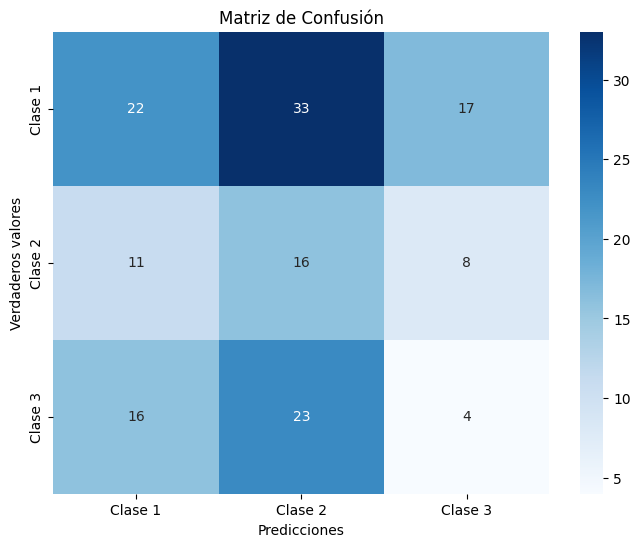

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_data, annot=True, cmap="Blues", fmt="d", xticklabels=["Clase 1", "Clase 2", "Clase 3"], yticklabels=["Clase 1", "Clase 2", "Clase 3"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Verdaderos valores")
plt.show()
